In [ ]:
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score

# Classifiers from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Neural Network
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Activation, ReLU, PReLU
import keras.backend as K

# Ignore warning messages 
import warnings
warnings.filterwarnings('ignore')

In [252]:
data = pd.read_csv('./diabetes.csv')

In [253]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Architecture Diagram
<img src="https://i.imgur.com/sASSsDe.png" width="700px">

### Exploratory Data Analysis

#### Glucose/Pregnancies vs Age

When a person’s age is less than 30, and their blood glucose level is less than 120 mg/dL or their number of pregnancies is less than 6, they are less likely to have diabetes.

<img src="https://i.imgur.com/ryy0QBx.png" width="700px">

#### BMI/Blood Pressure vs Glucose

When a person’s blood glucose level is less than 105 mg/dL, and their BMI less than 30 or blood pressure is less than 80 mmHg, they are less prone to diabetes.

<img src="https://i.imgur.com/A5hIVsZ.png" width="700px">

#### BMI vs Skin Thickness

When a person’s BMI is less than 30 and their skin thickness is less than 20 mm, they are less susceptible to diabetes.

<img src="https://i.imgur.com/6Ji7yO5.png" width="700px">

#### Outlier Analysis

<img src="https://i.imgur.com/QaEFF01.png" width="700px">

### Data Preprocessing

In [254]:
# Outlier Removal

# Z Score
z = np.abs(stats.zscore(data))
data = data[(z < 3).all(axis=1)]

# IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Replace with mean
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'Age']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'Age']].replace(0,np.NaN)
data.loc[(data['Insulin'].isnull()), 'Insulin'] = data['Insulin'].mean()
data.loc[(data['Glucose'].isnull()), 'Glucose'] = data['Glucose'].mean()
data.loc[(data['BloodPressure'].isnull()), 'BloodPressure'] = data['BloodPressure'].mean()
data.loc[(data['SkinThickness'].isnull()), 'SkinThickness'] = data['SkinThickness'].mean()
data.loc[(data['BMI'].isnull()), 'BMI'] = data['BMI'].mean()

insulin_mean = data['Insulin'].mean()
glucose_mean = data['Glucose'].mean()
bp_mean = data['BloodPressure'].mean()
skin_mean = data['SkinThickness'].mean()
bmi_mean = data['BMI'].mean()

In [255]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               619 non-null    int64  
 1   Glucose                   619 non-null    float64
 2   BloodPressure             619 non-null    float64
 3   SkinThickness             619 non-null    float64
 4   Insulin                   619 non-null    float64
 5   BMI                       619 non-null    float64
 6   DiabetesPedigreeFunction  619 non-null    float64
 7   Age                       619 non-null    int64  
 8   Outcome                   619 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 48.4 KB


In [257]:
data = data.reset_index(drop=True)

target_col = ["Outcome"]
num_cols = [x for x in data.columns if x not in target_col]

# Label encoding Binary columns
le = LabelEncoder()
for i in target_col:
    data[i] = le.fit_transform(data[i])

# Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

# Dropping original values and merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols, axis = 1)
data = data.merge(scaled, left_index=True, right_index=True, how = "left")

In [258]:
data.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,0.693913,1.039024,0.016340,7.869435e-01,-3.008166e-16,0.264157,0.847286,1.675116
1,0,-0.853393,-1.158428,-0.530386,6.974939e-02,-3.008166e-16,-0.836094,-0.301143,-0.116702
2,1,1.312836,2.259831,-0.712628,4.246642e-16,-3.008166e-16,-1.354783,1.034530,-0.022396
3,0,-0.853393,-1.018907,-0.530386,-6.474447e-01,-6.579198e-01,-0.600326,-1.066763,-1.059764
4,0,0.384452,-0.077142,0.198582,4.246642e-16,-3.008166e-16,-0.993272,-0.925289,-0.211008


In [259]:
# Define X and Y
X = data.drop('Outcome', 1)
y = data['Outcome']

In [260]:
# 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Neural Network

In [270]:
tf.random.set_seed = 1234
model = models.Sequential(name="pimamodel")
model.add(Input(shape=[X.shape[1]], name="Features"))
model.add(Dense(128))
model.add(PReLU())
model.add(Dense(64))
model.add(PReLU())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizers.Adam(), metrics=['accuracy'])

In [271]:
model.summary()

Model: "pimamodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 128)               1152      
                                                                 
 p_re_lu_38 (PReLU)          (None, 128)               128       
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 p_re_lu_39 (PReLU)          (None, 64)                64        
                                                                 
 dense_69 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________


In [272]:
mc = tf.keras.callbacks.ModelCheckpoint('best_model_nn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 10% validation split taken
history_model = model.fit(
  X_train, y_train,
  batch_size=32,
  epochs=50, validation_split=0.1, verbose=1, callbacks=[mc]
)

Epoch 1/50
 1/14 [=>............................] - ETA: 12s - loss: 0.7019 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to best_model_nn.h5
14/14 [==============================] - 1s 19ms/step - loss: 0.6058 - accuracy: 0.6449 - val_loss: 0.4850 - val_accuracy: 0.7200
Epoch 2/50
10/14 [====================>.........] - ETA: 0s - loss: 0.4775 - accuracy: 0.7656
Epoch 2: val_accuracy improved from 0.72000 to 0.80000, saving model to best_model_nn.h5
14/14 [==============================] - 1s 69ms/step - loss: 0.4960 - accuracy: 0.7438 - val_loss: 0.4071 - val_accuracy: 0.8000
Epoch 3/50
 1/14 [=>............................] - ETA: 0s - loss: 0.3838 - accuracy: 0.8750
Epoch 3: val_accuracy did not improve from 0.80000
14/14 [==============================] - 0s 4ms/step - loss: 0.4610 - accuracy: 0.7775 - val_loss: 0.3734 - val_accuracy: 0.8000
Epoch 4/50
 1/14 [=>............................] - ETA: 0s - loss: 0.5091 - accuracy: 0.7812
Epoch 4:

=====> Scoring Custom Network <=====
4/4 [==============================] - 0s 2ms/step
Accuracy: 0.7983870967741935
Precision: 0.6129032258064516
Recall: 0.59375
F1 Score: 0.6031746031746031


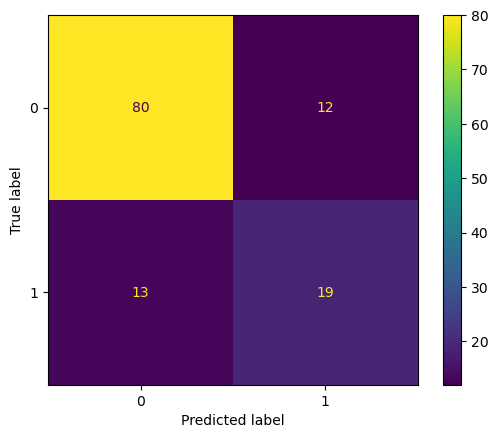

In [273]:
def score_custom_network(y_train, y_test):    
    print("=====> Scoring Custom Network <=====")
    
    model.load_weights('best_model_nn.h5')
    preds = model.predict(X_test)
    preds = preds.flatten()
    y_pred = np.where(preds > 0.5, 1, 0)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print ("Accuracy:", accuracy_score(y_test, y_pred))
    print ("Precision:", precision_score(y_test, y_pred))
    print ("Recall:", recall_score(y_test, y_pred))
    print ("F1 Score:", f1_score(y_test, y_pred))

score_custom_network(y_train, y_test)

In [ ]:
# Single testcase - Neural Network
def score_single_input(features):    
    print("=====> Scoring Custom Network <=====")
    model.load_weights('best_model_nn.h5')
    
    df = pd.DataFrame(features, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']) 
    
    # Data Preprocessing
    data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'Age']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'Age']].replace(0,np.NaN)
    data.loc[(data['Insulin'].isnull()), 'Insulin'] = insulin_mean
    data.loc[(data['Glucose'].isnull()), 'Glucose'] = glucose_mean
    data.loc[(data['BloodPressure'].isnull()), 'BloodPressure'] = bp_mean
    data.loc[(data['SkinThickness'].isnull()), 'SkinThickness'] = skin_mean
    data.loc[(data['BMI'].isnull()), 'BMI'] = bmi_mean
    
    # Scaling
    input_features = std.transform(features)
    scaled = pd.DataFrame(input_features, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    preds = model.predict(scaled)
    preds = preds.flatten()
    y_pred = np.where(preds > 0.5, 1, 0)
    print (y_pred)

score_single_input([[1, 85, 66, 29, 0, 26.6, 0.351, 31]]) # No diabetes
score_single_input([[8, 183, 64, 0, 0, 23.3, 0.672, 32]]) # Diabetes

=====> Scoring Custom Network <=====
1/1 [==============================] - 0s 24ms/step
[0]
=====> Scoring Custom Network <=====
1/1 [==============================] - 0s 24ms/step
[1]


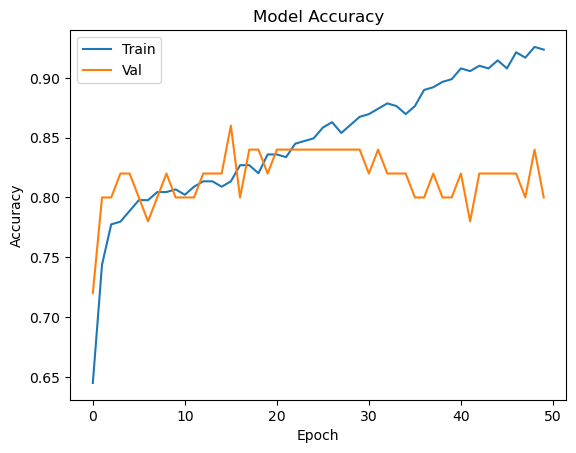

In [274]:
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Logistic Regression

Accuracy: 0.8306451612903226
Precision 0.7037037037037037
Recall: 0.59375
F1 Score: 0.6440677966101694


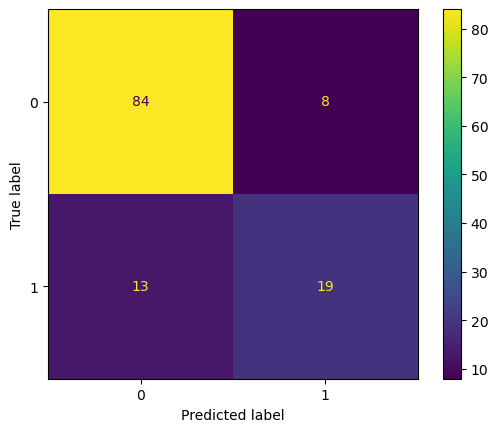

In [275]:
lreg = LogisticRegression(random_state=1234, max_iter=10000)
lreg.fit(X_train, y_train)
preds = lreg.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, preds)
print ("Accuracy:", accuracy_score(y_test, preds))
print ("Precision", precision_score(y_test, preds))
print ("Recall:", recall_score(y_test, preds))
print ("F1 Score:", f1_score(y_test, preds))

### Decision Tree

Accuracy: 0.75
Precision: 0.5142857142857142
Recall: 0.5625
F1 Score: 0.5373134328358209


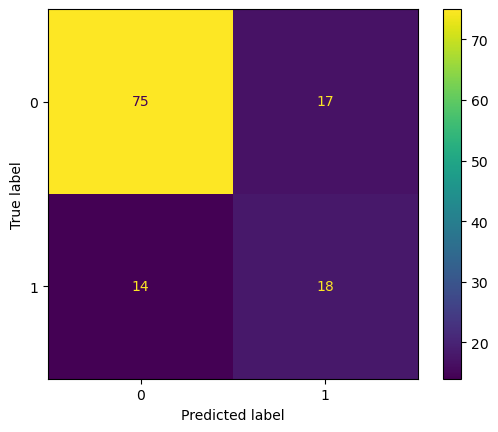

In [284]:
dt = DecisionTreeClassifier(random_state=1234, criterion='entropy')
dt.fit(X_train, y_train)
preds = dt.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds)
print ("Accuracy:", accuracy_score(y_test, preds))
print ("Precision:", precision_score(y_test, preds))
print ("Recall:", recall_score(y_test, preds))
print ("F1 Score:", f1_score(y_test, preds))

### Gaussian Naive Bayes

Accuracy: 0.7580645161290323
Precision: 0.5277777777777778
Recall: 0.59375
F1 Score: 0.5588235294117648


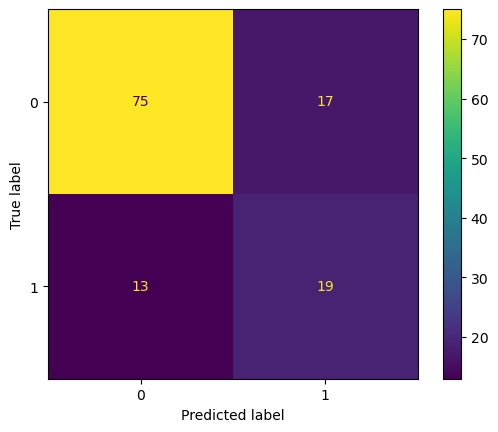

In [278]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
preds = gnb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds)
print ("Accuracy:", accuracy_score(y_test, preds))
print ("Precision:", precision_score(y_test, preds))
print ("Recall:", recall_score(y_test, preds))
print ("F1 Score:", f1_score(y_test, preds))

### K-Nearest Neighbours

Accuracy: 0.8064516129032258
Precision: 0.6428571428571429
Recall: 0.5625
F1 Score: 0.6000000000000001


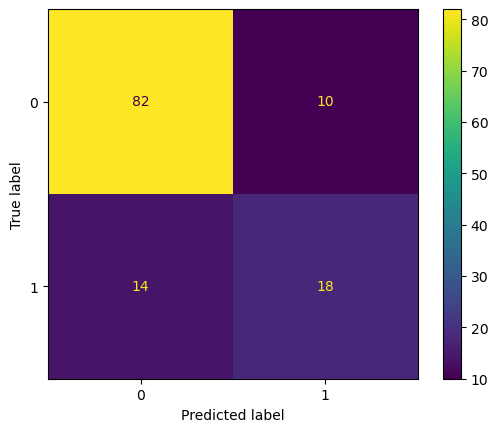

In [277]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds)
print ("Accuracy:", accuracy_score(y_test, preds))
print ("Precision:", precision_score(y_test, preds))
print ("Recall:", recall_score(y_test, preds))
print ("F1 Score:", f1_score(y_test, preds))